In [1]:
# Let's start by importing all the required libraries
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import matplotlib
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from zipfile import ZipFile
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [2]:
# I have attached the dataset from my google drive where I had a collection of about 5000 colored handmade sign images.

#Preparing Data

In [3]:
with ZipFile("train.zip","r") as zip_ref:
  zip_ref.extractall("data")

In [4]:
data_dir = './data'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes) 

['train']
['Y', 'G', 'M', 'L', 'Q', 'O', 'F', 'G_invert', 'C', 'B', 'A', 'V']


In [5]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.transforms import ToTensor

In [6]:
# Here for image transformation we are resizing the images to a 64 X 64 pixel format and then turning it to tensor for further processing.

In [120]:
dataset = ImageFolder(data_dir+'/train', transform=torchvision.transforms.Compose(
        [torchvision.transforms.Resize([64,64]), torchvision.transforms.ToTensor()]))


In [121]:
print(dataset[7212])

(tensor([[[0.0667, 0.1569, 0.1608,  ..., 0.1255, 0.1451, 0.1137],
         [0.1686, 0.3922, 0.4000,  ..., 0.2549, 0.2667, 0.2000],
         [0.2235, 0.5255, 0.5059,  ..., 0.3059, 0.3020, 0.2157],
         ...,
         [0.0471, 0.1059, 0.1098,  ..., 0.4235, 0.4353, 0.3216],
         [0.0510, 0.1137, 0.1020,  ..., 0.4235, 0.4314, 0.3216],
         [0.0314, 0.0549, 0.0471,  ..., 0.3098, 0.3098, 0.2314]],

        [[0.0784, 0.1725, 0.1725,  ..., 0.1176, 0.1216, 0.0980],
         [0.1961, 0.4588, 0.4471,  ..., 0.2196, 0.2235, 0.1843],
         [0.2667, 0.6196, 0.6000,  ..., 0.2431, 0.2353, 0.1804],
         ...,
         [0.0667, 0.1294, 0.1137,  ..., 0.4157, 0.4118, 0.3098],
         [0.0588, 0.1137, 0.1059,  ..., 0.4118, 0.4078, 0.3137],
         [0.0314, 0.0549, 0.0510,  ..., 0.3216, 0.3176, 0.2431]],

        [[0.8471, 0.6941, 0.6863,  ..., 0.6471, 0.6510, 0.7373],
         [0.7176, 0.4353, 0.4196,  ..., 0.2353, 0.2471, 0.4196],
         [0.7922, 0.6039, 0.5882,  ..., 0.2431, 0.2471, 0

In [122]:

def show_example(img, label):
  print('img.shape:', img.shape)
  print('Label: ', dataset.classes[label], "("+str(label)+")")
  plt.imshow(img.permute(1, 2, 0), cmap='gray')

In [123]:
#Shown below are some examples of the dataset images.

In [124]:
print(len(dataset))

7940


img.shape: torch.Size([3, 64, 64])
Label:  B (1)


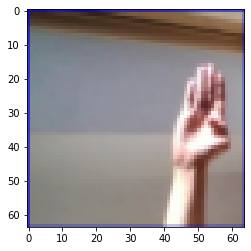

In [125]:
show_example(*dataset[1184])

img.shape: torch.Size([3, 64, 64])
Label:  A (0)


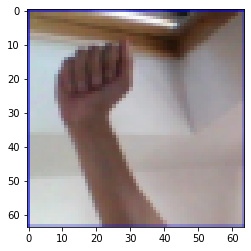

In [126]:
show_example(*dataset[140])

In [127]:
# Now we divide the dataset into training and validation set. I have taken about 5 percent of the dataset into validation.

In [128]:
val_size = int(0.05*len(dataset))
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(7543, 397)

In [129]:
random_seed = 120
torch.manual_seed(random_seed);

In [130]:
# Now from the training dataset, we take out 50 images for testing purposes.

In [131]:
print(train_size)
test_size=50
train_size = len(train_ds) - test_size

train_ds, test_ds = random_split(train_ds, [train_size, test_size])
len(train_ds), len(test_ds)

7543


(7493, 50)

img.shape: torch.Size([3, 64, 64])
Label:  O (8)


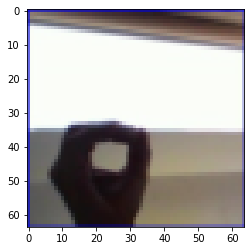

In [132]:
show_example(*test_ds[0])

In [133]:
from torch.utils.data.dataloader import DataLoader
batch_size=128

In [134]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [135]:
# After the data has been loaded by the dataloader, we define some functions for accuracy and image classification.

In [136]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [137]:
# Shown below is the model used. We have 4 convolutional layers each followed by the RELU i.e. Rectified Linear Unit and Max Pooling Layer to train on 4765 images.


In [138]:
class SignLangCnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 32X32

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 16 x 16

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 8 x 8

            nn.Flatten(), 
            nn.Linear(16384, 8192),
            nn.ReLU(),
            nn.Linear(8192, 1024),
            nn.ReLU(),
            nn.Linear(1024, 24))
        
    def forward(self, xb):
        return self.network(xb)

In [139]:
model = SignLangCnnModel()
model

SignLangCnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=16384, out_features=8192, bias=True)
    (17): ReLU()
    (18): Linear(in_fe

In [140]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape: torch.Size([128, 3, 64, 64])
out.shape: torch.Size([128, 24])
out[0]: tensor([-0.0120,  0.0170,  0.0238, -0.0095,  0.0183, -0.0278,  0.0294,  0.0309,
        -0.0143, -0.0118, -0.0049,  0.0158,  0.0089, -0.0189,  0.0227,  0.0048,
        -0.0140,  0.0203, -0.0100, -0.0212, -0.0125, -0.0033,  0.0196, -0.0283],
       grad_fn=<SelectBackward>)


In [141]:
import torch

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [142]:
# It's better to use a GPU if available to save time on training the model.

In [143]:
device = get_default_device()
device

device(type='cuda')

In [144]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [145]:
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [146]:
# After defining all the functions and classes we now train the model for 7 epochs and a learning rate (lr) of 0.0001 and analyse the results.

In [153]:
num_epochs =7
opt_func = torch.optim.Adam
lr = 0.001

In [154]:
evaluate(model, val_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.840827226638794, 'val_loss': 0.44330453872680664}

In [155]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 3.6820, val_loss: 1.3271, val_acc: 0.5076
Epoch [1], train_loss: 0.8386, val_loss: 0.6505, val_acc: 0.7805
Epoch [2], train_loss: 0.3908, val_loss: 0.4297, val_acc: 0.8499
Epoch [3], train_loss: 0.2017, val_loss: 0.1836, val_acc: 0.9455
Epoch [4], train_loss: 0.1093, val_loss: 0.1476, val_acc: 0.9601
Epoch [5], train_loss: 0.0647, val_loss: 0.1710, val_acc: 0.9423
Epoch [6], train_loss: 0.0524, val_loss: 0.0772, val_acc: 0.9757


In [156]:
#As can be seen in the cell above, the model reached about 99.6 % accuracy after which it decreased and came to 97 percent.

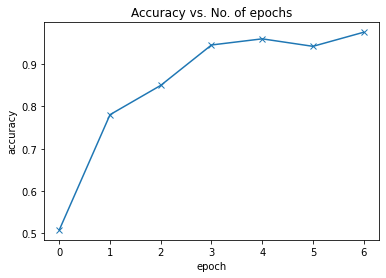

In [157]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
plot_accuracies(history)

In [158]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

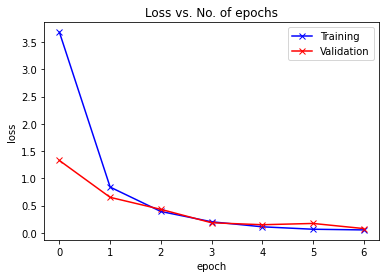

In [159]:
plot_losses(history)

In [160]:
#After all the plots have been plotted and we got an idea of our model performance, we save the metrics along with the model.

In [161]:
# It's time to test our efforts now. I made a function that takes an image and gives us the classification using the model we just trained.

In [226]:
import torch.nn.functional as F
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Apply softmax for each output row
    probs = F.softmax(yb, dim=1)
    print("Confidence (%) :",torch.max(probs).item()*100)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

In [174]:
dataset.classes

['A', 'B', 'C', 'F', 'G', 'G_invert', 'L', 'M', 'O', 'Q', 'V', 'Y']

Confidence (%) : 99.65699911117554
Label: O , Predicted: O


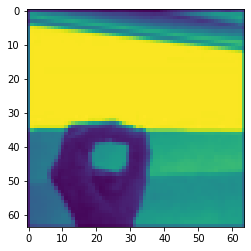

In [228]:
img, label = test_ds[0]
plt.imshow(img[0])
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Confidence (%) : 88.35586309432983
Label: A , Predicted: A


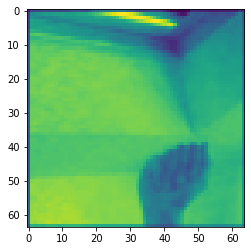

In [229]:
img, label = test_ds[3]
plt.imshow(img[0])
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Confidence (%) : 99.99432563781738
Label: L , Predicted: L


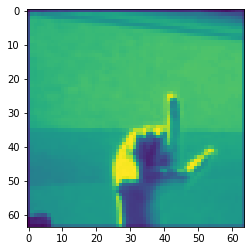

In [230]:
img, label = test_ds[26]
plt.imshow(img[0])
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [237]:
# Imports PIL module 
from PIL import Image

img=Image.open("frame359.jpg")
 
# intial dimension
img=np.array(img)
print("Initial dimensions: ",img.shape)

 # transforming to tensor
from torchvision import transforms
tr=transforms.ToTensor()
img_tensor=tr(img)

 # resizing tensor
resize_tensor=transforms.Resize([64,64])
img_tensor=resize_tensor(img_tensor)
print("Final shape of tensor: ",img_tensor.shape)

Initial dimensions:  (480, 640, 3)
Final shape of tensor:  torch.Size([3, 64, 64])


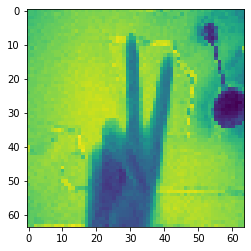

In [238]:
plt.imshow(img_tensor[0])

In [239]:
print(" Predicted: ",predict_image(img_tensor,model))

Confidence (%) : 96.2763249874115
 Predicted:  G_invert


In [186]:
test_loader = DeviceDataLoader(DataLoader(test_ds, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_acc': 0.9800000190734863, 'val_loss': 0.056217409670352936}

In [ ]:
# So far so good, we have a test set accuracy of 98% and all the images I randomly predicted came right. As this parameters gave us very impressive results, we must log the metrics.

## Save and upload

In [240]:
saved_weights_fname='sign-recognition.pth'

In [ ]:
torch.save(model.state_dict(), saved_weights_fname)